## Applications v03

Updates: 

- K is updated at each iteration to fit best-track Vmax

- f is updated at each iteration according to best-track

CAVEAT: Vmax SAR and Vmax IBTrACS need to be consitent with each other

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
}

PTHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'ibt_pth':         '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/03_APPLICATIONS/'
}

In [3]:
### Open IBTrACS
IBT_PRMS = {
    'ibt_vars2keep':  ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':  ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
}

ds_ibt_raw = xr.open_dataset(PTHS['ibt_pth'])
ds_ibt     = ds_ibt_raw[IBT_PRMS['ibt_vars2keep']]
ds_ibt[IBT_PRMS['ibt_info2keep']] = ds_ibt_raw[IBT_PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings

start_date = np.datetime64('2010-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
end_date   = np.datetime64('2023-01-01')
lsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - end_date))   # Last storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, lsi + 1))

### CONVERSIONS
# Convert to m/s and km units
ds_ibt['usa_wind']    *= 0.5144
ds_ibt['storm_speed'] *= 0.5144
ds_ibt['usa_r34']     *= 1.852
ds_ibt['usa_r50']     *= 1.852
ds_ibt['usa_r64']     *= 1.852
ds_ibt['usa_rmw']     *= 1.852

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### 1) Functions and model

In [4]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

In [47]:
### RESOLUTION
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def N(r, M):
    '''Rotational stability frequency'''
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                     # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})               # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})               # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt(((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def compute_lbda(r, V, fcor, R_plus, V_plus, gamma=1/40, Cd_plus=2e-3, K=10):
    M_abs = r * V + 0.5 * fcor * (r ** 2)
    M_rel = r * V
        
    left  = gamma * float(Cd_plus * (V_plus ** 2) * R_plus) / (fcor * M_abs)
    right = np.sqrt(N(r, M_abs) / (2 * K))
    lbda  = left * right
    
    return np.array(lbda)

###################
### CHARAC TIME ###
###################

def compute_tau_recirculation(r, V, fcor):
    vmx = np.nanmax(V)
    rmx = r[np.nanargmax(V)]
    r0  = np.sqrt(2 * vmx / (fcor * rmx)) * rmx
    v0  = V[r >= r0][0]
    return (r0 / v0) / 3600

#############
### MODEL ###
#############
def propagate_V(r, V_ini, fcor_ini, dt, K=20, gamma=1/40, Cd_plus=2.5e-3):    
    # Characteristic scales
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    L              = R_plus

    # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
    V_hol = smooth_with_holland(r, V_ini, fcor_ini)
    lbda  = compute_lbda(r, V_hol, fcor_ini, R_plus, V_plus, gamma, Cd_plus, K) # non-dimensional

    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * L),
        coords={'rad': r / L}
    )

    # Apply KK10
    V = v_k10(V_nrm, t=dt, lbda=lbda) * fcor_ini * L # dimensional
    
    return V

def binary_search(r, V_ini, fcors, vmxs, time_ini, K_low=0, K_hgh=100):
    # Debug
    vmx_ini  = float(vmxs.interp(coords={'time': time_ini}))
    print('Vmax ini = {:.1f} m/s'.format(vmx_ini))

    # Compute dt
    fcor_ini = float(fcors.interp(coords={'time': time_ini}))
    tau1     = (1 / fcor_ini) / 3600
    tau2     = compute_tau_recirculation(r, V_ini, fcor_ini) # Compute R0/V0
    # tau2     = compute_tau_recirculation(r, V_ini, fcor_ini) / 2 # Compute R0/V0
    dt       = tau2 / tau1
    
    # Compute Vmax to reach
    vmx_fin  = float(vmxs.interp(coords={'time': time_ini + np.timedelta64(int(tau2 * 3600), 's')}))
    print('Vmax fin = {:.1f} m/s'.format(vmx_fin))
    
    # Initialization of binary search
    err    = 999
    last_K = 999
    
    # Accepted error on Vmax is 1 m/s
    while abs(err) > 1:
        K_mid = (K_hgh + K_low) // 2
        print(K_mid)
        
        # Raise Error if K_mid = 0
        if K_mid == 0:
            raise KfitError

        # Compute model and error
        V        = propagate_V(r, V_ini, fcor_ini, dt, K=K_mid)
        err      = np.nanmax(V) - vmx_fin
        # plt.plot(r, V)

        if err > 0:
            K_hgh = K_mid - 1
        else:
            K_low = K_mid + 1
        
        if K_mid == last_K:
            err = 0
        last_K = K_mid
            
    return V, K_mid, tau2

def run_model_until(r, V_ini, fcors, vmxs, time_ini, time_fin):
    # Initialize
    vk10s = []
    vk10s.append(V_ini)
    time  = time_ini
    dt    = np.timedelta64(999, 's')
    
    # Iterate
    while time < time_fin + (dt / 2.):
        V, _, tau2 = binary_search(rs, vk10s[-1], fcors, vmxs, time, K_low=0, K_hgh=100)
        time      += np.timedelta64(int(tau2 * 3600), 's')
        vk10s.append(V)
        
    return vk10s

### K fit exception
class KfitError(Exception):
    "Raised when Kfit = 0 in the binary search"
    pass

### 3) Hector 2018

Text(0.5, 1.0, 'HECTOR, EP102018')

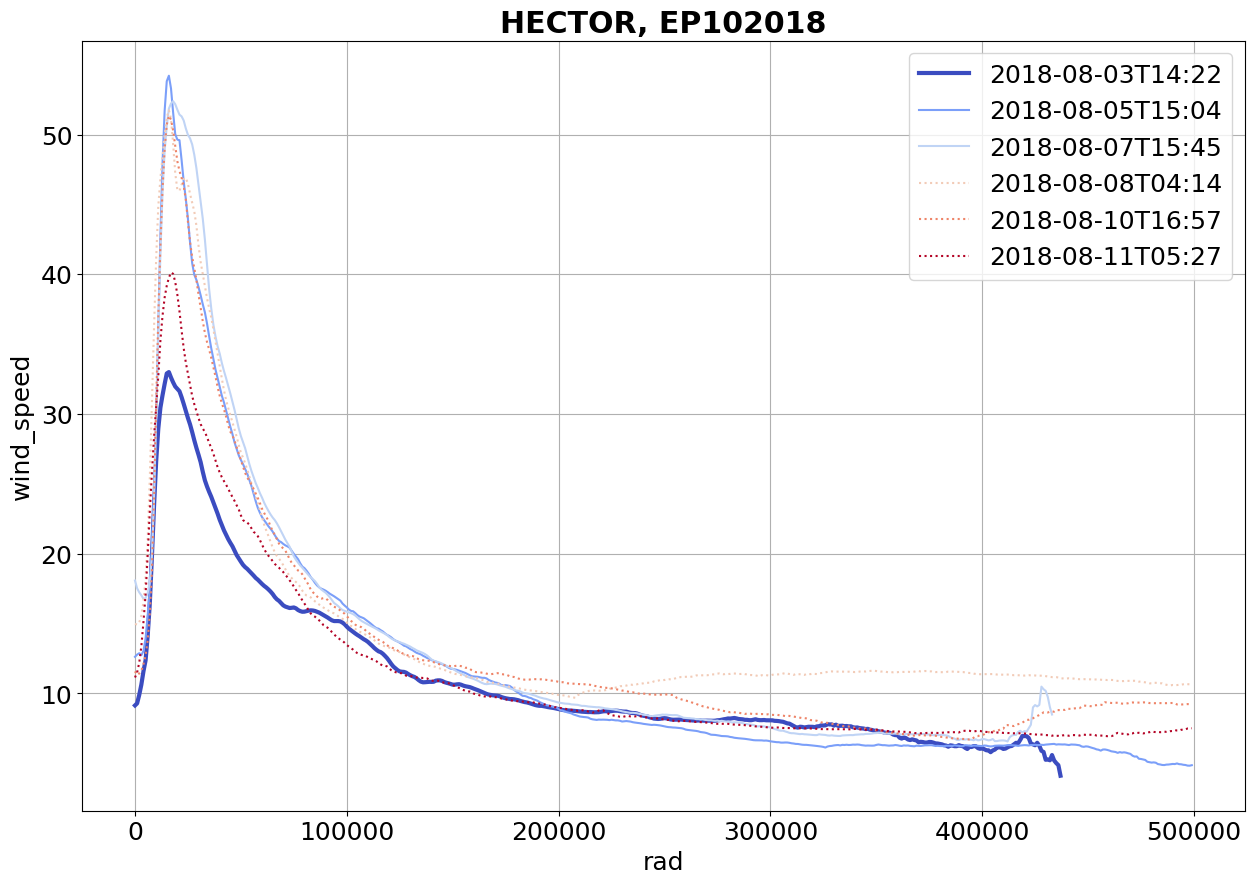

In [39]:
dsg = xr.open_dataset(PTHS['ds_glob_path'])

### HECTOR
p1    = 'rs2--owi-ca-20180803t142144-20180803t142259-00003-0444B_sw_ep102018_cyclone.nc'
p2    = 'rs2--owi-ca-20180805t150354-20180805t150510-00003-05A2E_sw_ep102018_cyclone.nc'
p3    = 'rs2--owi-ca-20180807t154512-20180807t154628-00003-07134_sw_ep102018_cyclone.nc'
p4    = 's1a-ew-owi-ca-20180808t041303-20180808t041507-000003-0283BF_sw_ep102018_cyclone.nc'
p5    = 's1b-ew-owi-ca-20180810t165606-20180810t165822-000003-0167B7_sw_ep102018_cyclone.nc'
p6    = 's1b-ew-owi-ca-20180811t052613-20180811t052854-000003-0167F5_sw_ep102018_cyclone.nc'

p1dsg = 'rs2--owi-cm-20180803t142144-20180803t142259-00003-0444B_sw.nc'
p2dsg = 'rs2--owi-cm-20180805t150354-20180805t150510-00003-05A2E_sw.nc'
p3dsg = 'rs2--owi-cm-20180807t154512-20180807t154628-00003-07134_sw.nc'
p4dsg = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc'
p5dsg = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_sw.nc'
p6dsg = 's1b-ew-owi-cm-20180811t052613-20180811t052854-000003-0167F5_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 6))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)
ds6 = xr.open_dataset(PTHS['sar_dir'] + p6).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)
ws6 = ds6.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
ws6.plot(label='{}'.format(np.datetime_as_string(ds6.time, unit='m')), c=colors[5], linestyle='dotted')
plt.grid();plt.legend();plt.title('HECTOR, EP102018', weight='bold')

In [40]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg, p6dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
DTS   = {} # Recirculation time (= Model update time)

In [41]:
atcf_id = 'EP102018'
dsi     = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id, drop=True).isel(storm=0)
vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})

/tmp/ipykernel_8185/3879147485.py:3: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
/tmp/ipykernel_8185/3879147485.py:4: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})


Vmax ini = 36.3 m/s
Vmax fin = 37.7 m/s
50
Vmax ini = 37.7 m/s
Vmax fin = 39.2 m/s
50
24
Vmax ini = 39.2 m/s
Vmax fin = 40.8 m/s
50
24
Vmax ini = 40.8 m/s
Vmax fin = 42.3 m/s
50
24
Vmax ini = 42.3 m/s
Vmax fin = 43.2 m/s
50
24
Vmax ini = 43.2 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 44.3 m/s
50
24
Vmax ini = 44.3 m/s
Vmax fin = 45.4 m/s
50
24
37
30
Vmax ini = 45.4 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.8 m/s
50
24
Vmax ini = 45.8 m/s
Vmax fin = 46.6 m/s
50
24
37


(0.0, 500.0)

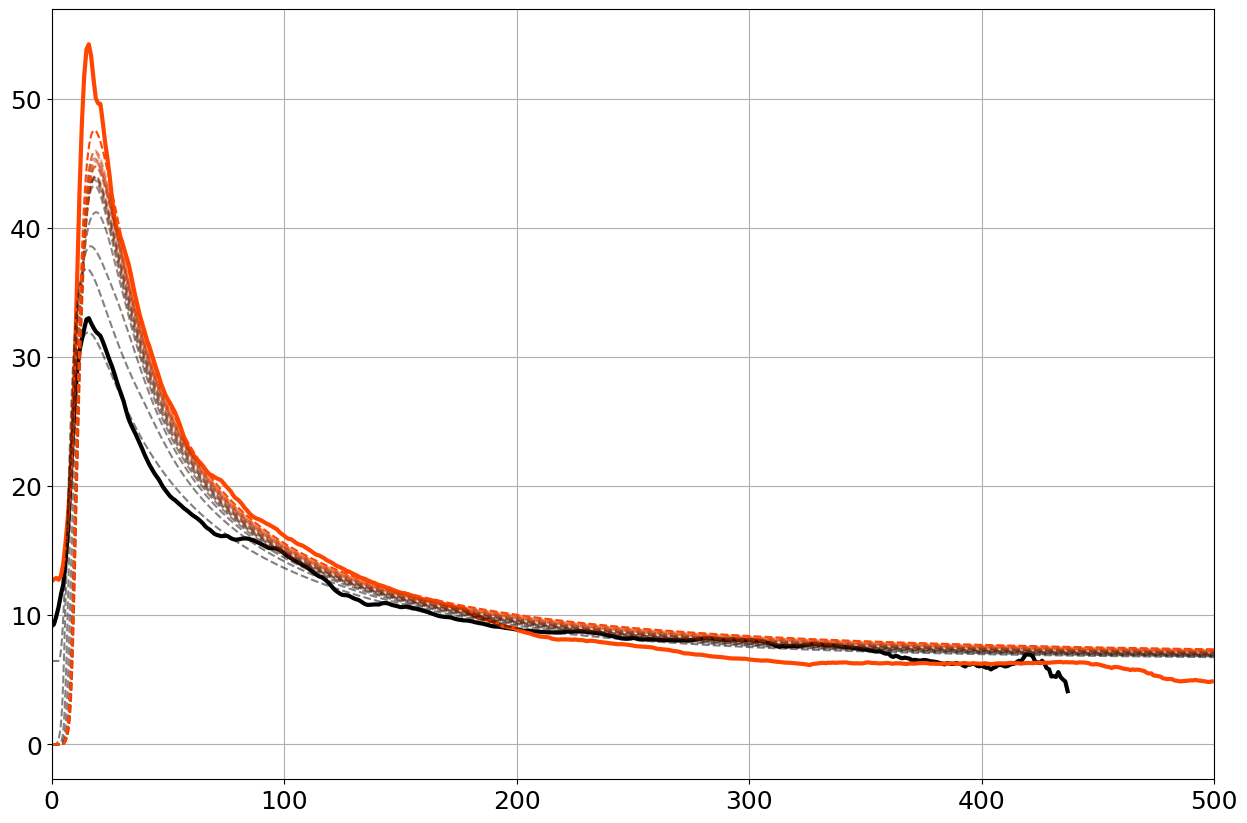

In [42]:
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 1)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 36.3 m/s
Vmax fin = 37.7 m/s
50
Vmax ini = 37.7 m/s
Vmax fin = 39.2 m/s
50
24
Vmax ini = 39.2 m/s
Vmax fin = 40.8 m/s
50
24
Vmax ini = 40.8 m/s
Vmax fin = 42.3 m/s
50
24
Vmax ini = 42.3 m/s
Vmax fin = 43.2 m/s
50
24
Vmax ini = 43.2 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 44.3 m/s
50
24
Vmax ini = 44.3 m/s
Vmax fin = 45.4 m/s
50
24
37
30
Vmax ini = 45.4 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.8 m/s
50
24
Vmax ini = 45.8 m/s
Vmax fin = 46.6 m/s
50
24
37
Vmax ini = 46.6 m/s
Vmax fin = 47.7 m/s
50
24
37
30
Vmax ini = 47.7 m/s
Vmax fin = 48.6 m/s
50
24
37
Vmax ini = 48.6 m/s
Vmax fin = 49.5 m/s
50
24
37
Vmax ini = 49.5 m/s
Vmax fin = 50.5 m/s
50
24
37
Vmax ini = 50.5 m/s
Vmax fin = 51.4 m/s
50
24
3

(0.0, 500.0)

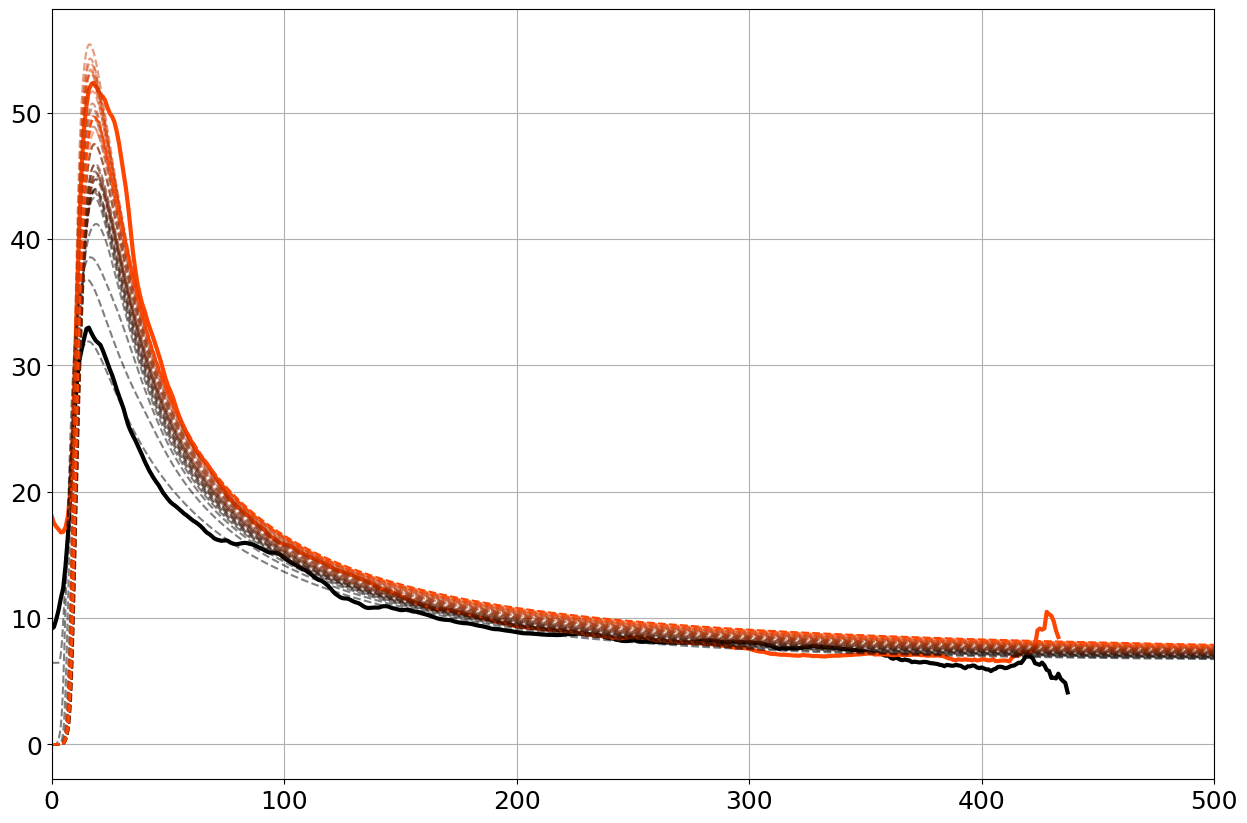

In [43]:
### TEST ON A LONGER PERIOD
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 2)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 2)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 36.3 m/s
Vmax fin = 37.7 m/s
50
Vmax ini = 37.7 m/s
Vmax fin = 39.2 m/s
50
24
Vmax ini = 39.2 m/s
Vmax fin = 40.8 m/s
50
24
Vmax ini = 40.8 m/s
Vmax fin = 42.3 m/s
50
24
Vmax ini = 42.3 m/s
Vmax fin = 43.2 m/s
50
24
Vmax ini = 43.2 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 44.3 m/s
50
24
Vmax ini = 44.3 m/s
Vmax fin = 45.4 m/s
50
24
37
30
Vmax ini = 45.4 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.8 m/s
50
24
Vmax ini = 45.8 m/s
Vmax fin = 46.6 m/s
50
24
37
Vmax ini = 46.6 m/s
Vmax fin = 47.7 m/s
50
24
37
30
Vmax ini = 47.7 m/s
Vmax fin = 48.6 m/s
50
24
37
Vmax ini = 48.6 m/s
Vmax fin = 49.5 m/s
50
24
37
Vmax ini = 49.5 m/s
Vmax fin = 50.5 m/s
50
24
37
Vmax ini = 50.5 m/s
Vmax fin = 51.4 m/s
50
24
3

(0.0, 500.0)

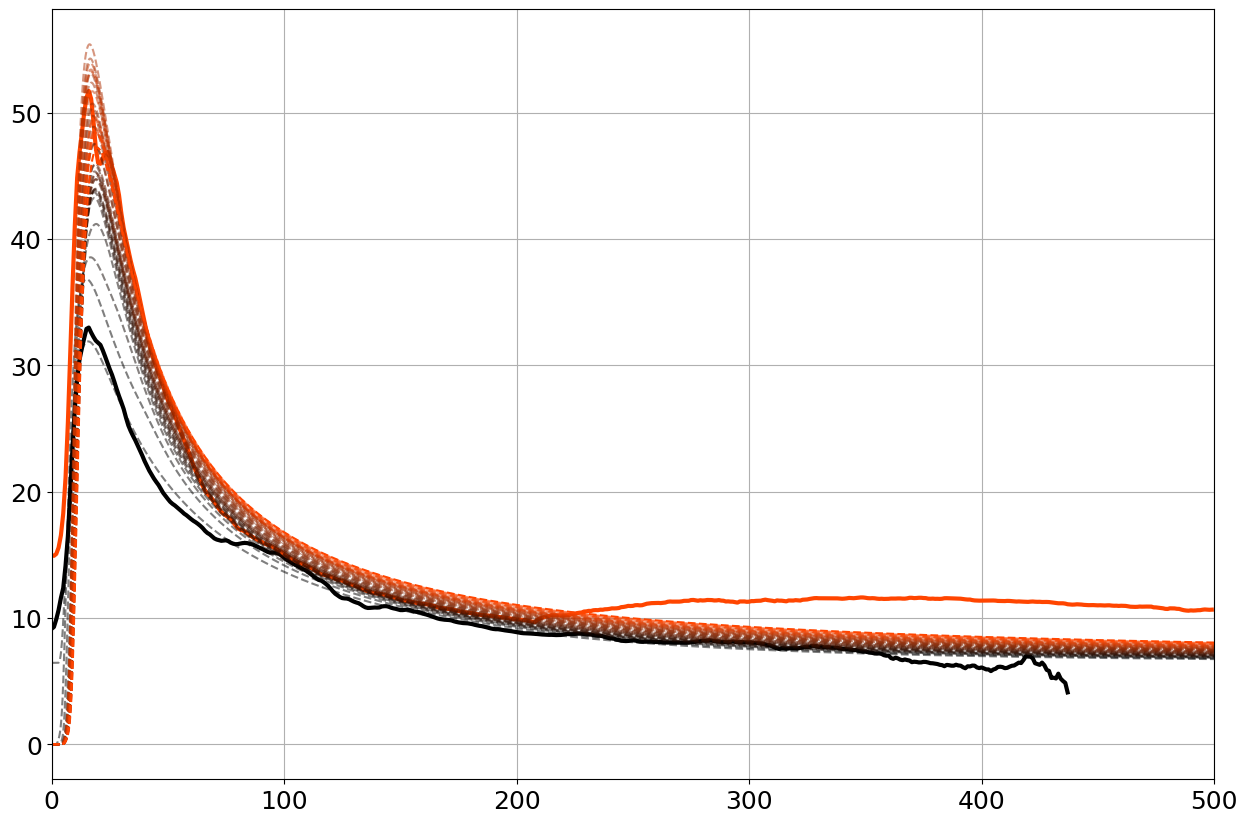

In [44]:
### TEST ON A LONGER PERIOD BIS
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 3)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 3)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 36.3 m/s
Vmax fin = 37.7 m/s
50
Vmax ini = 37.7 m/s
Vmax fin = 39.2 m/s
50
24
Vmax ini = 39.2 m/s
Vmax fin = 40.8 m/s
50
24
Vmax ini = 40.8 m/s
Vmax fin = 42.3 m/s
50
24
Vmax ini = 42.3 m/s
Vmax fin = 43.2 m/s
50
24
Vmax ini = 43.2 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 44.3 m/s
50
24
Vmax ini = 44.3 m/s
Vmax fin = 45.4 m/s
50
24
37
30
Vmax ini = 45.4 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.8 m/s
50
24
Vmax ini = 45.8 m/s
Vmax fin = 46.6 m/s
50
24
37
Vmax ini = 46.6 m/s
Vmax fin = 47.7 m/s
50
24
37
30
Vmax ini = 47.7 m/s
Vmax fin = 48.6 m/s
50
24
37
Vmax ini = 48.6 m/s
Vmax fin = 49.5 m/s
50
24
37
Vmax ini = 49.5 m/s
Vmax fin = 50.5 m/s
50
24
37
Vmax ini = 50.5 m/s
Vmax fin = 51.4 m/s
50
24
3

(0.0, 500.0)

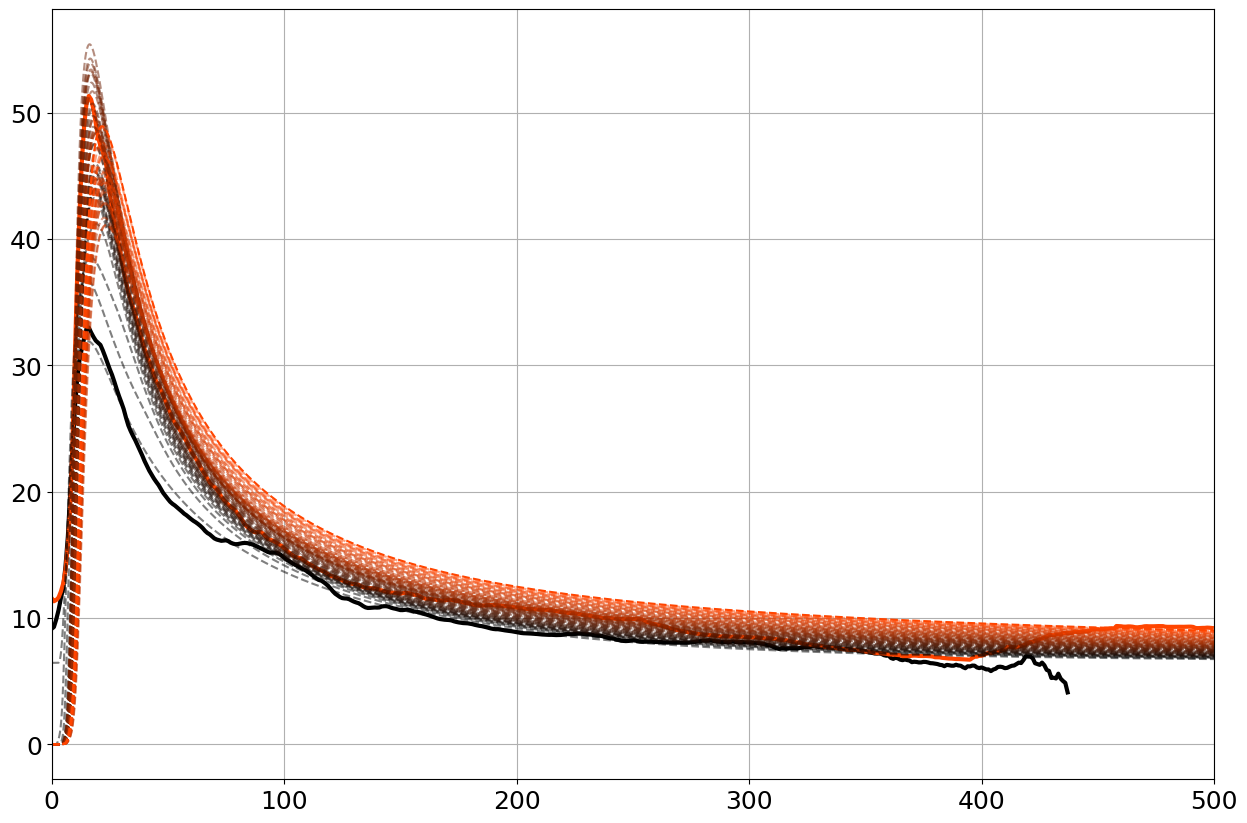

In [45]:
### TEST ON A LONGER PERIOD TER
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 4)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 4)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 36.3 m/s
Vmax fin = 37.7 m/s
50
Vmax ini = 37.7 m/s
Vmax fin = 39.2 m/s
50
24
Vmax ini = 39.2 m/s
Vmax fin = 40.8 m/s
50
24
Vmax ini = 40.8 m/s
Vmax fin = 42.3 m/s
50
24
Vmax ini = 42.3 m/s
Vmax fin = 43.2 m/s
50
24
Vmax ini = 43.2 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
Vmax ini = 43.8 m/s
Vmax fin = 44.3 m/s
50
24
Vmax ini = 44.3 m/s
Vmax fin = 45.4 m/s
50
24
37
30
Vmax ini = 45.4 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
37
30
Vmax ini = 45.6 m/s
Vmax fin = 45.8 m/s
50
24
Vmax ini = 45.8 m/s
Vmax fin = 46.6 m/s
50
24
37
Vmax ini = 46.6 m/s
Vmax fin = 47.7 m/s
50
24
37
30
Vmax ini = 47.7 m/s
Vmax fin = 48.6 m/s
50
24
37
Vmax ini = 48.6 m/s
Vmax fin = 49.5 m/s
50
24
37
Vmax ini = 49.5 m/s
Vmax fin = 50.5 m/s
50
24
37
Vmax ini = 50.5 m/s
Vmax fin = 51.4 m/s
50
24
3

(0.0, 500.0)

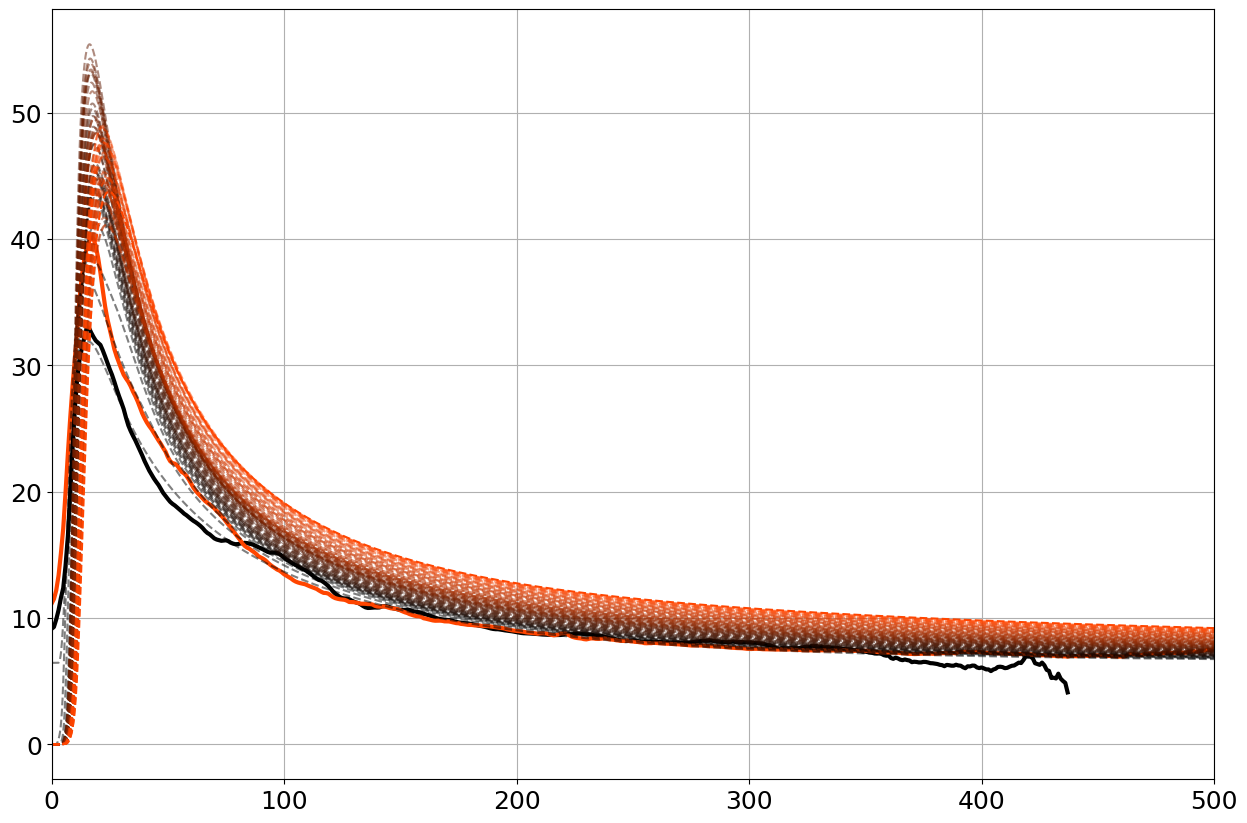

In [46]:
### TEST ON A LONGER PERIOD TER
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 5)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 5)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

### 2) Marie 2020

Text(0.5, 1.0, 'MARIE, EP182020')

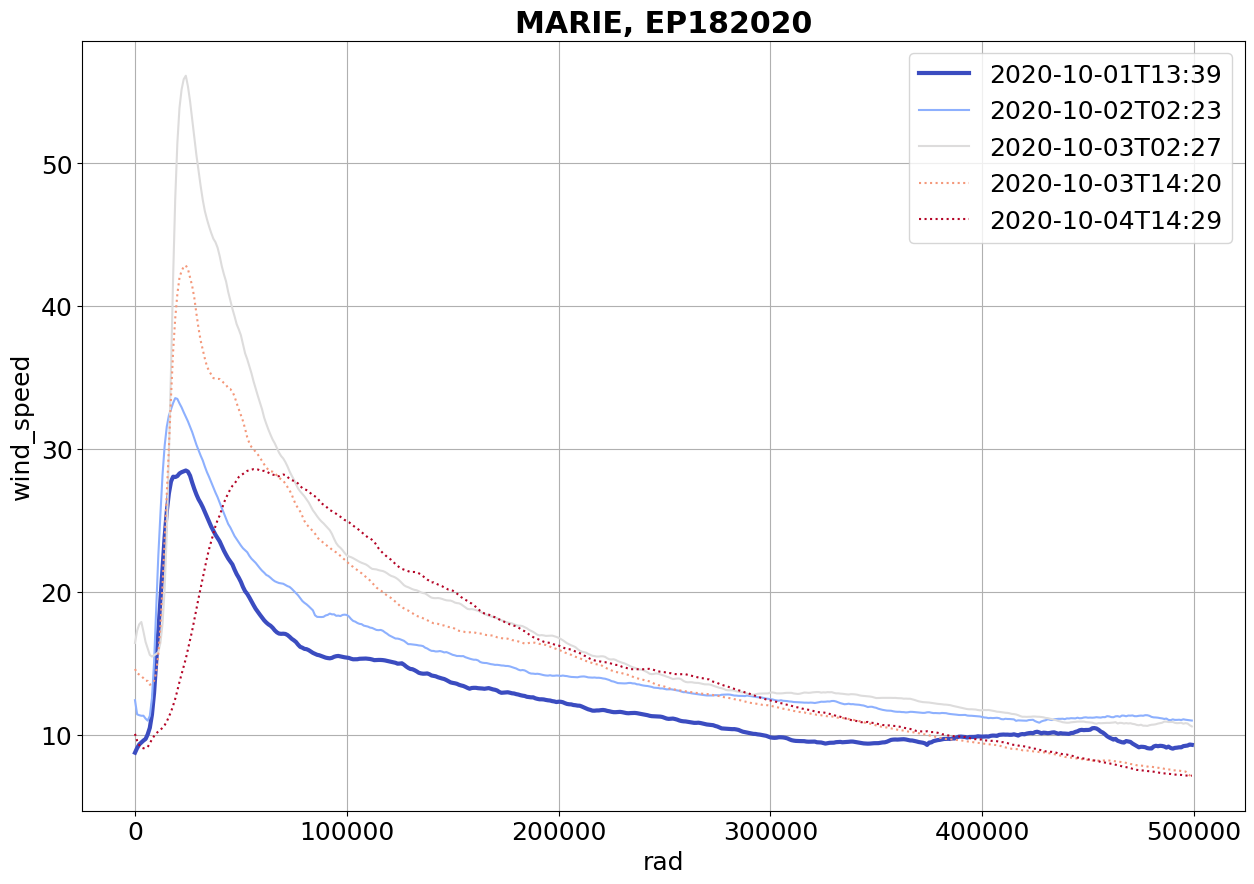

In [14]:
### MARIE
p1    = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2    = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3    = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4    = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5    = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

p1dsg = 'rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc'
p2dsg = 'rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc'
p3dsg = 's1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc'
p4dsg = 'rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc'
p5dsg = 's1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

In [15]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg, p6dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
DTS   = {} # Recirculation time (= Model update time)

In [16]:
atcf_id = 'EP182020'
dsi     = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id, drop=True).isel(storm=0)
vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})

/tmp/ipykernel_8185/676043048.py:3: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
/tmp/ipykernel_8185/676043048.py:4: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})


Vmax ini = 37.7 m/s
Vmax fin = 40.1 m/s
50
75
88
94
97
99
100
Vmax ini = 40.1 m/s
Vmax fin = 42.8 m/s
50
24
Vmax ini = 42.8 m/s
Vmax fin = 46.8 m/s
50
24
37


(0.0, 500.0)

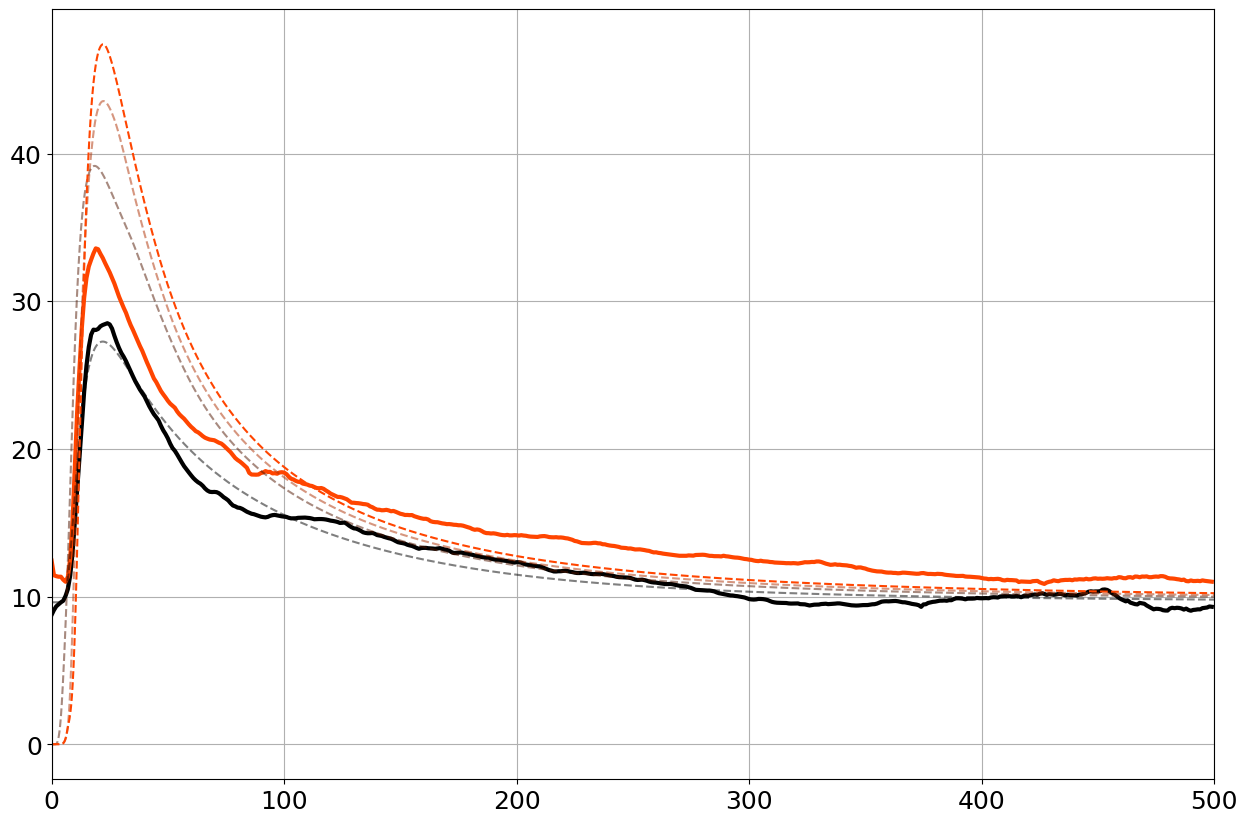

In [17]:
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 1)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 37.7 m/s
Vmax fin = 40.1 m/s
50
75
88
94
97
99
100
Vmax ini = 40.1 m/s
Vmax fin = 42.8 m/s
50
24
Vmax ini = 42.8 m/s
Vmax fin = 46.8 m/s
50
24
37
Vmax ini = 46.8 m/s
Vmax fin = 49.2 m/s
50
24
37
Vmax ini = 49.2 m/s
Vmax fin = 48.4 m/s
50
24
37
Vmax ini = 48.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30


(0.0, 500.0)

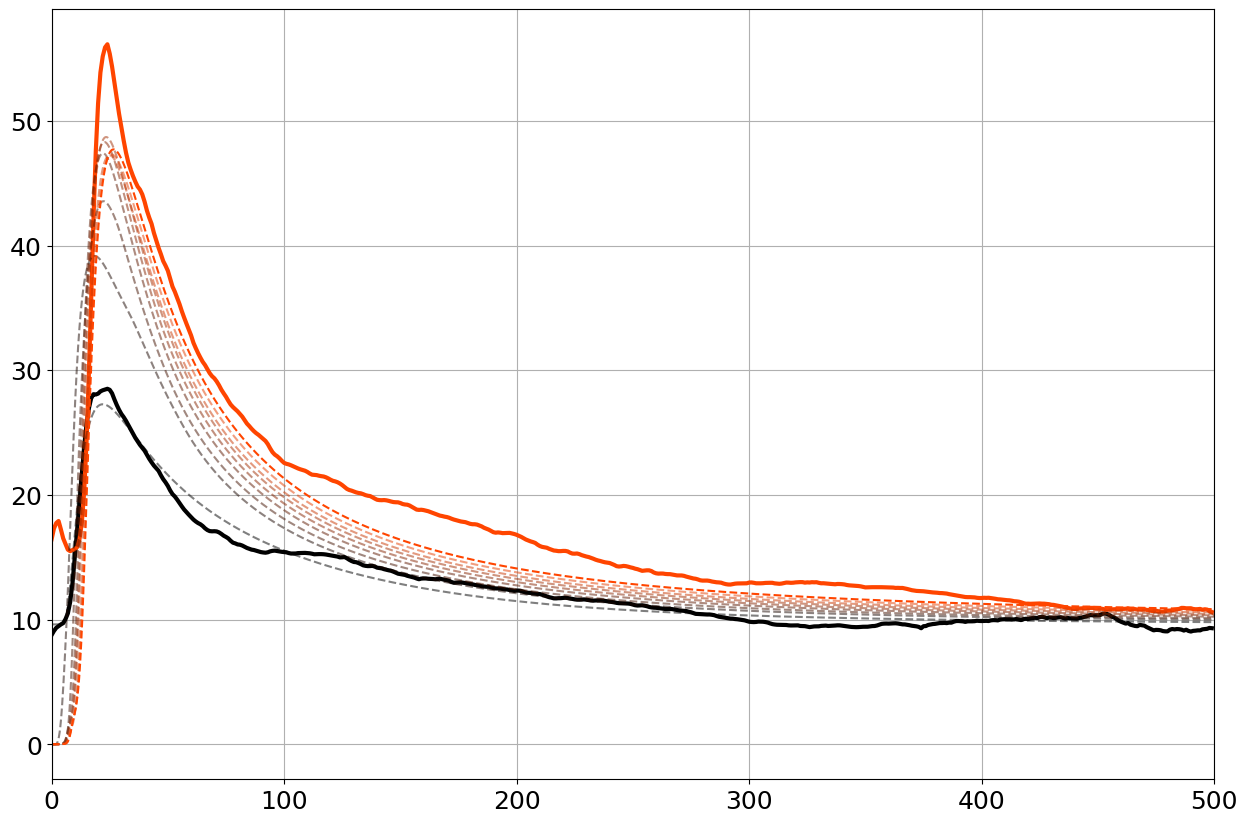

In [18]:
### TEST ON A LONGER PERIOD
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 2)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 2)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 37.7 m/s
Vmax fin = 40.1 m/s
50
75
88
94
97
99
100
Vmax ini = 40.1 m/s
Vmax fin = 42.8 m/s
50
24
Vmax ini = 42.8 m/s
Vmax fin = 46.8 m/s
50
24
37
Vmax ini = 46.8 m/s
Vmax fin = 49.2 m/s
50
24
37
Vmax ini = 49.2 m/s
Vmax fin = 48.4 m/s
50
24
37
Vmax ini = 48.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 45.9 m/s
50
24
Vmax ini = 45.9 m/s
Vmax fin = 44.3 m/s
50
24
11
17


(0.0, 500.0)

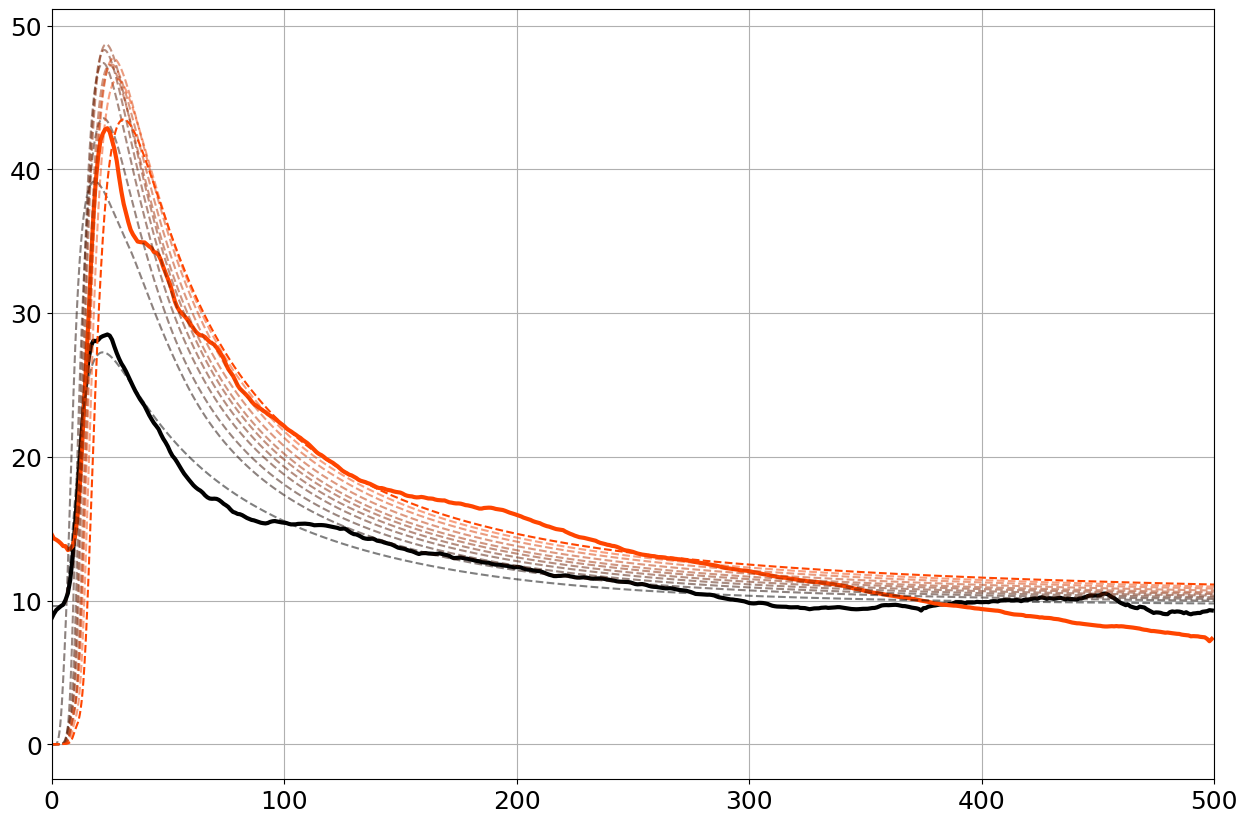

In [19]:
### TEST ON A LONGER PERIOD BIS
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 3)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 3)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 37.7 m/s
Vmax fin = 40.1 m/s
50
75
88
94
97
99
100
Vmax ini = 40.1 m/s
Vmax fin = 42.8 m/s
50
24
Vmax ini = 42.8 m/s
Vmax fin = 46.8 m/s
50
24
37
Vmax ini = 46.8 m/s
Vmax fin = 49.2 m/s
50
24
37
Vmax ini = 49.2 m/s
Vmax fin = 48.4 m/s
50
24
37
Vmax ini = 48.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 47.4 m/s
50
24
37
30
Vmax ini = 47.4 m/s
Vmax fin = 45.9 m/s
50
24
Vmax ini = 45.9 m/s
Vmax fin = 44.3 m/s
50
24
11
17
Vmax ini = 44.3 m/s
Vmax fin = 42.8 m/s
50
24
11
17
Vmax ini = 42.8 m/s
Vmax fin = 40.9 m/s
50
24
11
Vmax ini = 40.9 m/s
Vmax fin = 38.0 m/s
50
24
11
5
8
Vmax ini = 38.0 m/s
Vmax fin = 35.1 m/s
50
24
11
5
Vmax ini = 35.1 m/s
Vmax fin = 32.2 m/s
50
24
11
5
2
3
4


(0.0, 500.0)

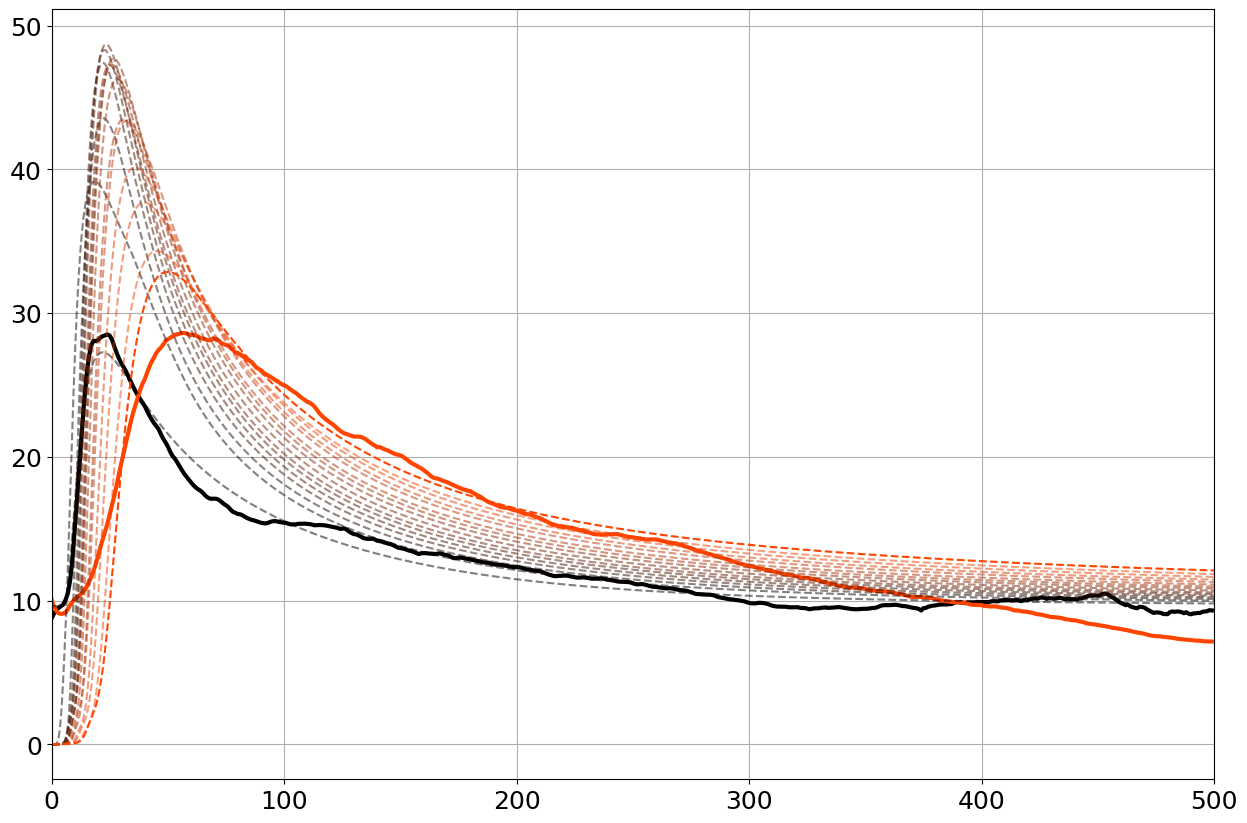

In [20]:
### TEST ON A LONGER PERIOD TER
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 4)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 4)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

### 4) Larry 2021

Text(0.5, 1.0, 'LARRY')

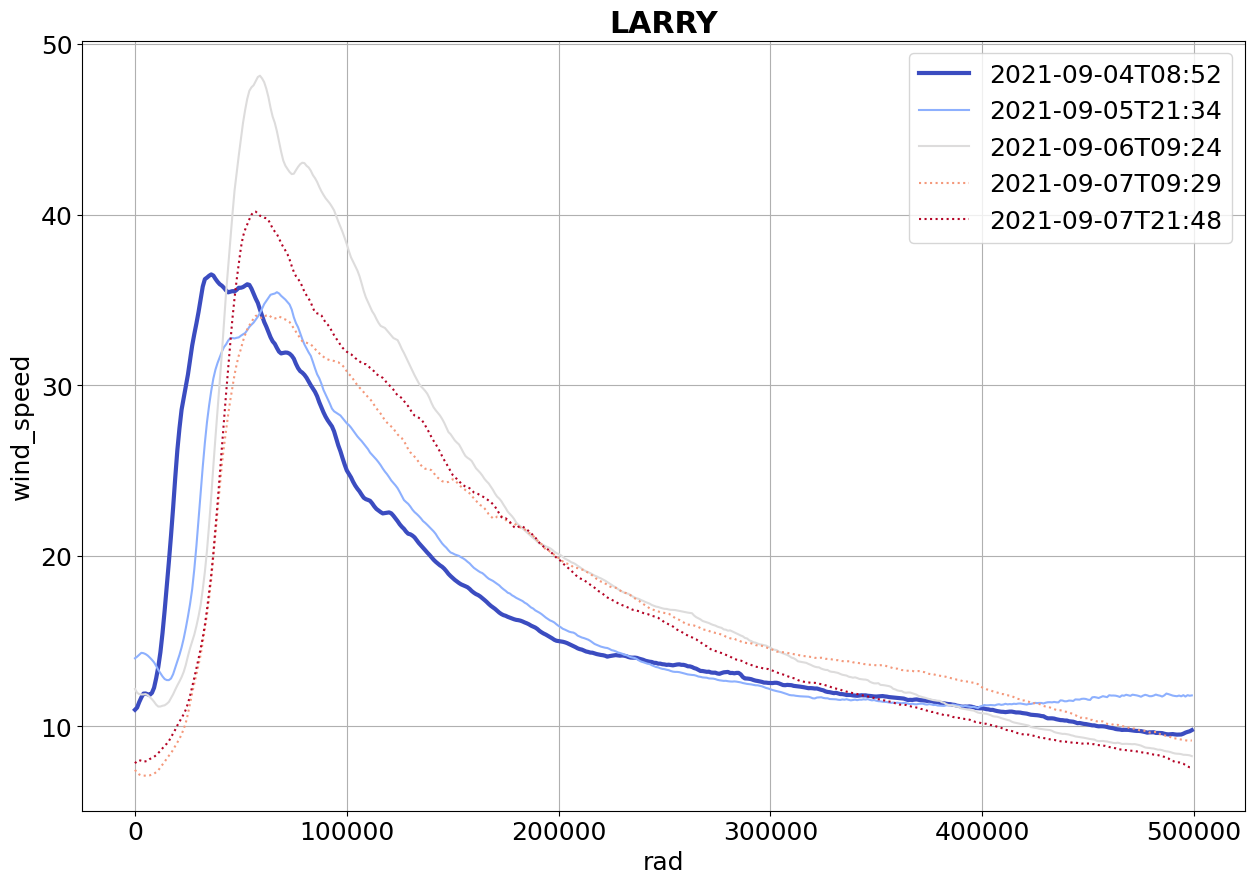

In [21]:
### LARRY
p1    = 's1b-ew-owi-ca-20210904t085102-20210904t085352-000003-036818_sw_al122021_cyclone.nc'
p2    = 'rs2--owi-ca-20210905t213342-20210905t213606-00003-1E37F_sw_al122021_cyclone.nc'
p3    = 's1a-ew-owi-ca-20210906t092329-20210906t092604-000003-04ACFC_sw_al122021_cyclone.nc'
p4    = 'rs2--owi-ca-20210907t092755-20210907t093019-00003-1F5B6_sw_al122021_cyclone.nc'
p5    = 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone.nc'

p1dsg = 's1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc'
p2dsg = 'rs2--owi-cm-20210905t213342-20210905t213606-00003-1E37F_sw.nc'
p3dsg = 's1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc'
p4dsg = 'rs2--owi-cm-20210907t092755-20210907t093019-00003-1F5B6_sw.nc'
p5dsg = 's1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('LARRY', weight='bold')

In [22]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg, p6dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
DTS   = {} # Recirculation time (= Model update time)

In [23]:
atcf_id = 'AL122021'
dsi     = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id, drop=True).isel(storm=0)
vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})

/tmp/ipykernel_8185/2198843517.py:3: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  vmxs    = 0.6967 * dsi.usa_wind.rename({'date_time': 'time'}) + 6.1992
/tmp/ipykernel_8185/2198843517.py:4: UserWarning: rename 'date_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  fcors   = abs(coriolis(dsi.usa_lat)).rename({'date_time': 'time'})


Vmax ini = 45.6 m/s
Vmax fin = 44.8 m/s
50
24
11
17
Vmax ini = 44.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 44.4 m/s
50
24
11
17
Vmax ini = 44.4 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.3 m/s
50
24
11
17
14


(0.0, 500.0)

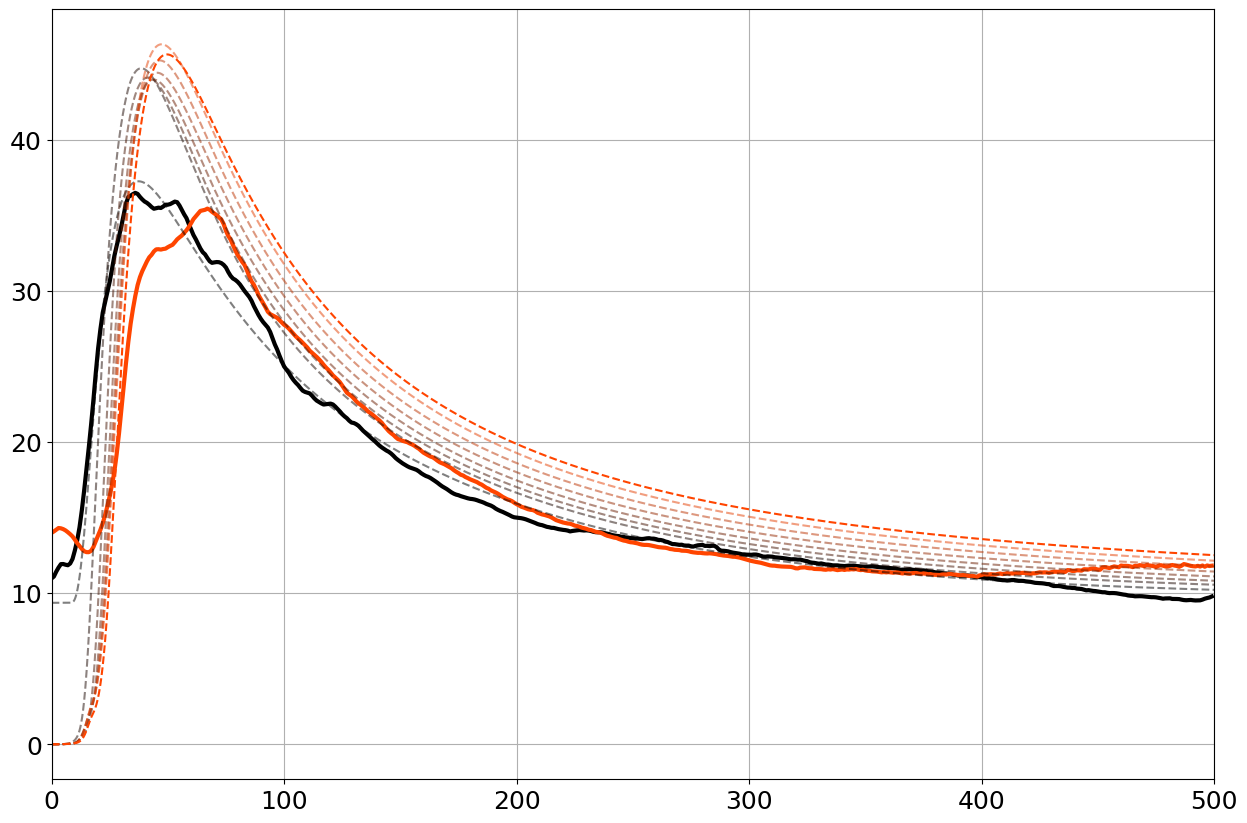

In [24]:
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 1)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 45.6 m/s
Vmax fin = 44.8 m/s
50
24
11
17
Vmax ini = 44.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 44.4 m/s
50
24
11
17
Vmax ini = 44.4 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.3 m/s
50
24
11
17
14
Vmax ini = 45.3 m/s
Vmax fin = 43.8 m/s
50
24
11
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
9


(0.0, 500.0)

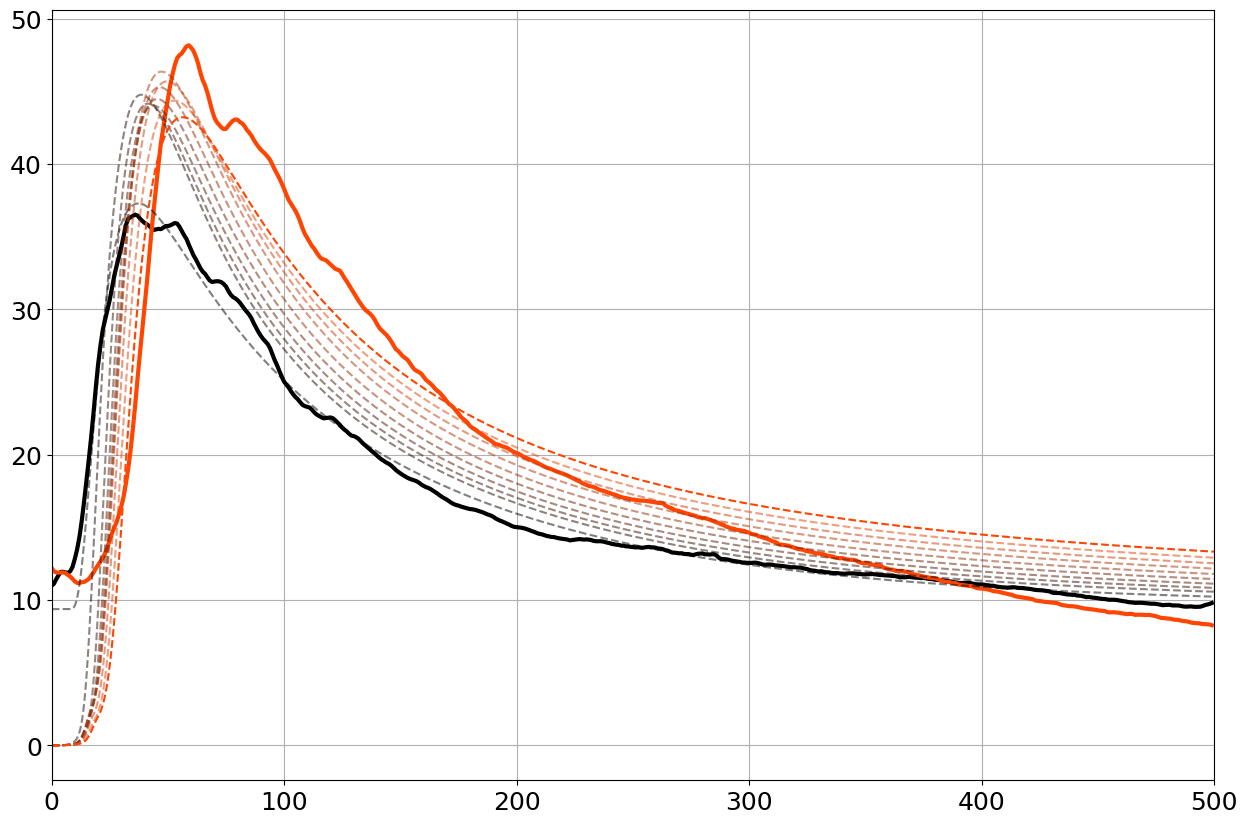

In [25]:
### TEST ON A LONGER PERIOD
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 2)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 2)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 45.6 m/s
Vmax fin = 44.8 m/s
50
24
11
17
Vmax ini = 44.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 44.4 m/s
50
24
11
17
Vmax ini = 44.4 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.3 m/s
50
24
11
17
14
Vmax ini = 45.3 m/s
Vmax fin = 43.8 m/s
50
24
11
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
9
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
9
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
Vmax ini = 43.8 m/s
Vmax fin = 43.0 m/s
50
24
11
5
8
6
7
Vmax ini = 43.0 m/s
Vmax fin = 41.7 m/s
50
24
11
5
Vmax ini = 41.7 m/s
Vmax fin = 40.3 m/s
50
24
11
5
2
3
4


(0.0, 500.0)

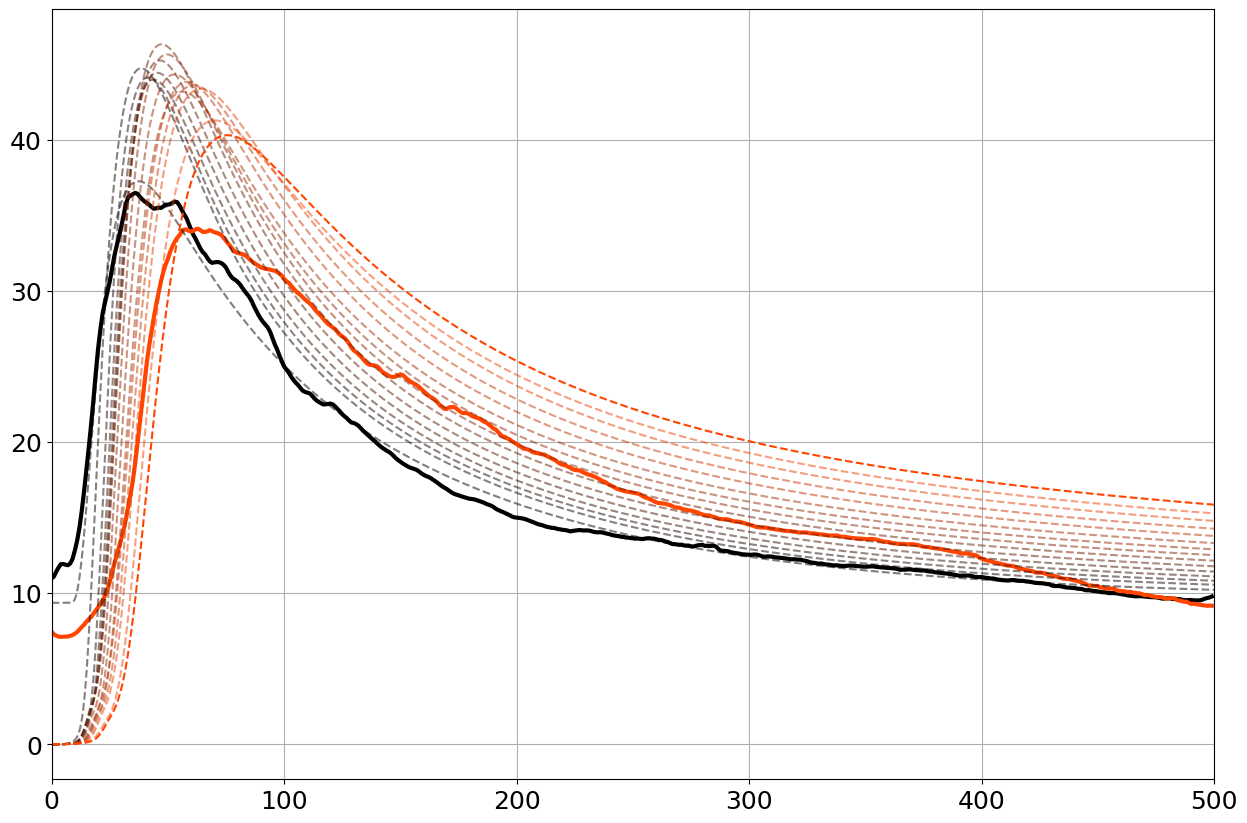

In [26]:
### TEST ON A LONGER PERIOD BIS
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 3)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 3)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)

Vmax ini = 45.6 m/s
Vmax fin = 44.8 m/s
50
24
11
17
Vmax ini = 44.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
17
Vmax ini = 43.8 m/s
Vmax fin = 44.4 m/s
50
24
11
17
Vmax ini = 44.4 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.6 m/s
50
24
11
17
Vmax ini = 45.6 m/s
Vmax fin = 45.3 m/s
50
24
11
17
14
Vmax ini = 45.3 m/s
Vmax fin = 43.8 m/s
50
24
11
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
9
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
9
Vmax ini = 43.8 m/s
Vmax fin = 43.8 m/s
50
24
11
5
8
Vmax ini = 43.8 m/s
Vmax fin = 43.0 m/s
50
24
11
5
8
6
7
Vmax ini = 43.0 m/s
Vmax fin = 41.7 m/s
50
24
11
5
Vmax ini = 41.7 m/s
Vmax fin = 40.3 m/s
50
24
11
5
2
3
4
Vmax ini = 40.3 m/s
Vmax fin = 40.2 m/s
50
24
11
5
2
3
4
3
3
Vmax ini = 40.2 m/s
Vmax fin = 40.2 m/s
50
24
11
5
2
3
Vmax ini = 40.2 m/s
Vmax fin = 40.2 m/s
50
24
11
5
2
3


(0.0, 500.0)

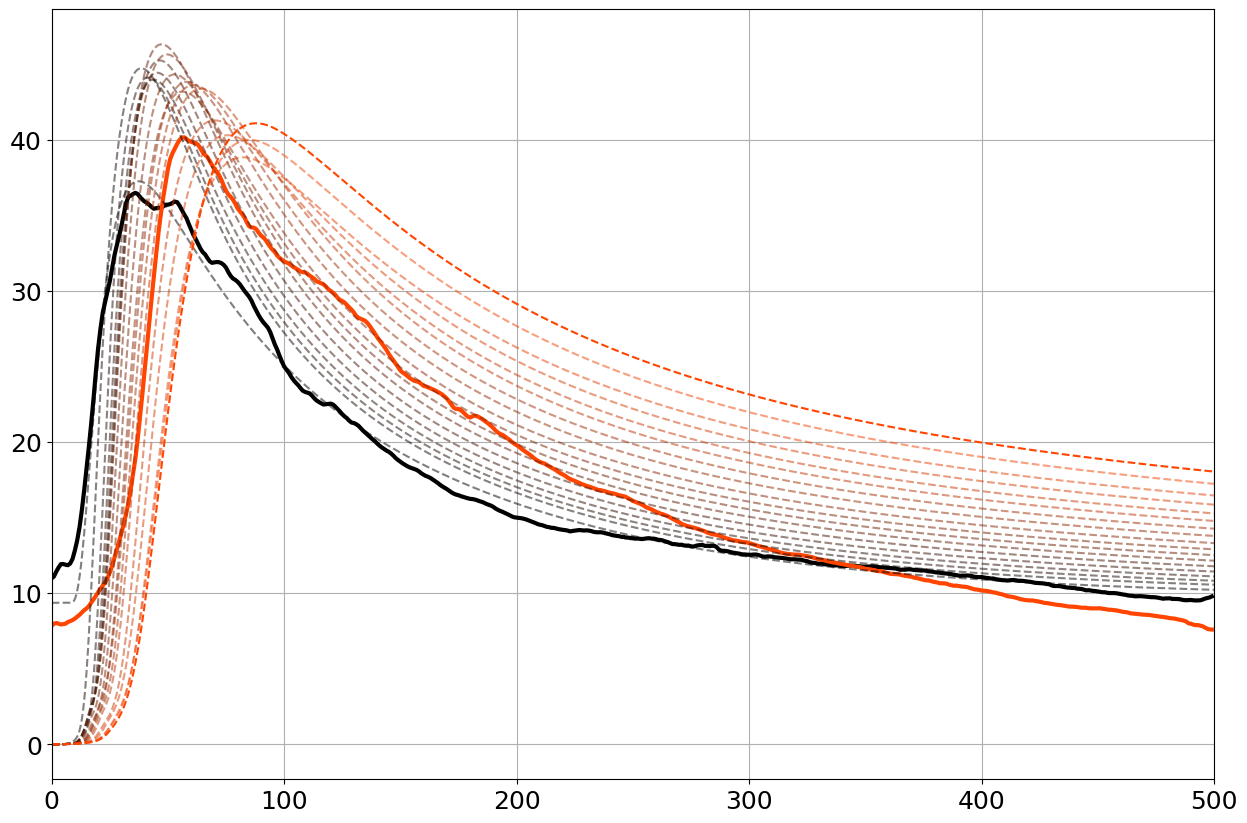

In [27]:
### TEST ON A LONGER PERIOD TER
i     = 0
VK10S = run_model_until(rs, VHS[str(i)], fcors, vmxs, DS[str(i)].time.copy(deep=True), DS[str(i + 4)].time.copy(deep=True))

# SAR
plt.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
plt.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 4)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))

# MODEL
l    = len(VK10S)
clrs = cm(np.linspace(0, 1, l))
for k in range(l - 1):
    plt.plot(rs / 1000, VK10S[k],  c=clrs[k], linestyle='dashed', alpha=0.5) 
plt.plot(rs / 1000, VK10S[l - 1],  c=clrs[l - 1], linestyle='dashed') 
    
plt.grid()
plt.xlim(0, 500)